# Sentiment Analysis on Europe Hotel Reviews

Pooja Umathe

Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. 

### Data:

This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. Meanwhile, the geographical location of hotels are also provided for further analysis.

Data Content
The csv file contains 17 fields. The description of each field is as below:

Hotel_Address: Address of hotel.

Review_Date: Date when reviewer posted the corresponding review.

Average_Score: Average Score of the hotel, calculated based on the latest comment in the last year.

Hotel_Name: Name of Hotel

Reviewer_Nationality: Nationality of Reviewer

Negative_Review: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'

ReviewTotalNegativeWordCounts: Total number of words in the negative review.

Positive_Review: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'

ReviewTotalPositiveWordCounts: Total number of words in the positive review.

Reviewer_Score: Score the reviewer has given to the hotel, based on his/her experience

TotalNumberofReviewsReviewerHasGiven: Number of Reviews the reviewers has given in the past.

TotalNumberof_Reviews: Total number of valid reviews the hotel has.

Tags: Tags reviewer gave the hotel.

dayssincereview: Duration between the review date and scrape date.

AdditionalNumberof_Scoring: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

lat: Latitude of the hotel

lng: longtitude of the hotel

In [32]:
# Import required libraries

import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [33]:
# Importing the data 

reviews_df = pd.read_csv("Hotel_Reviews.csv")
reviews_df.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


In [34]:
# Getting the shape of data

reviews_df.shape

(515738, 17)

In [35]:
# Getting the info of data

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738 non-null flo

In [36]:
# Appending the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]

# creation of label by spliting into two categories:
# bad reviews have overall ratings < 5 and good reviews have overall ratings >= 5

reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)

# selecting relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


In [37]:
# Data Sampling

reviews_df = reviews_df.sample(frac = 0.2, replace = False, random_state=42)

In [38]:
reviews_df.shape

(103148, 2)

In [39]:
# Data Cleaning

# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [40]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))
reviews_df.head(5)

Wall time: 7min 43s


,review,is_bad_review,review_clean
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...
274649,No tissue paper box was present at the room,0,tissue paper box present room
374688,Pillows Nice welcoming and service,0,pillow nice welcome service
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff


In [41]:
# Feature Engineering

Adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel.We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:

neutrality score

positivity score

negativity score

an overall score that summarizes the previous scores

In [42]:
# Adding sentiment column

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

Adding some simple metrics for every text:

number of characters in the text

number of words in the text

In [43]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [44]:
!python -m pip install -U gensim

Requirement already up-to-date: gensim in c:\users\pooja\anaconda3\lib\site-packages (3.8.1)


Now, We need to train the model but for that we need to get each review into vector representation.

In [45]:
# create doc2vec vector columns

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [47]:
reviews_df.head(5)

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,0.012375,0.179975,-0.111247,0.131502,-0.278525
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,-0.028433,0.092035,0.001125,-0.037368,0.094533
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.069241,0.051814,-0.104086,0.033881,-0.098680
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.067516,-0.028071,-0.063982,0.049848,-0.109490
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.021974,-0.040154,-0.073998,-0.053956,-0.055387


The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks.Those similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and we can use those vectors as our training features.

First we need to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [12]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

Now we are adding the TF-IDF (Term Frequency — Inverse Document Frequency) values for each word and document.

TF computes the classic number of times the word appears in the text
IDF computes the relative importance of this word which depends on how many texts the word can be found
We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [48]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,0.012375,0.179975,-0.111247,0.131502,-0.278525
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,-0.028433,0.092035,0.001125,-0.037368,0.094533
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.069241,0.051814,-0.104086,0.033881,-0.098680
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.067516,-0.028071,-0.063982,0.049848,-0.109490
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.021974,-0.040154,-0.073998,-0.053956,-0.055387


In [49]:
reviews_df.shape

(103148, 14)

In [50]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.956393
1    0.043607
Name: is_bad_review, dtype: float64

As we can see from the above normalization result, our data is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

In [51]:
!python -m pip install wordcloud

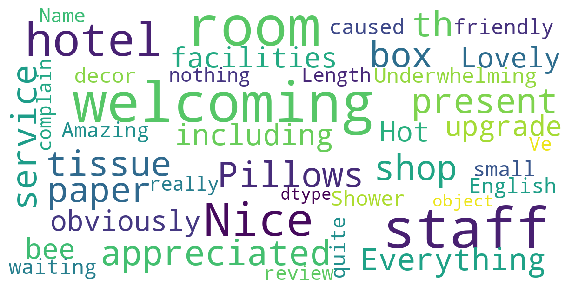

In [63]:
# wordcloud function

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [64]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
180510,A super friendly welcome,1.000
173978,clean comfortable attractive,1.000
43101,A perfect location comfortable great value,0.931
192385,Clean comfortable friendly helpful staff,0.923
263366,Friendly Smiling Efficient Helpful staff,0.922
388503,Efficient friendly smiling fair price,0.919
384291,Super helpful friendly staff,0.908
211742,Clean comfortable lovely staff,0.907
55329,Clean comfortable excellent location,0.907
175551,Friendly welcome Comfortable room,0.905


In [65]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
319196,Nothing Classy calm perfect,0.880
476092,All No no no,0.868
67391,Abusive sarcastic m staff,0.861
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
257984,Nothing Friendly courteous happy staff,0.806
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
82994,Nothing Great feeling excellent staff,0.793


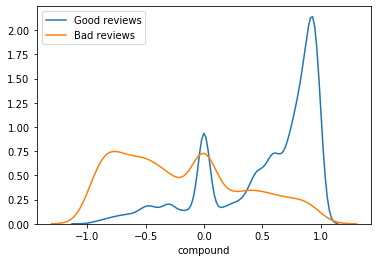

In [66]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores. This shows us that previously computed sentiment features will be very important in our modelling part.

In [67]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], 
                                                    test_size = 0.20, random_state = 42)

In [68]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.144111
10,doc2vec_vector_4,0.106639
7,doc2vec_vector_1,0.103015
6,doc2vec_vector_0,0.095159
9,doc2vec_vector_3,0.093847
8,doc2vec_vector_2,0.093773
4,nb_chars,0.083904
2,pos,0.076786
0,neg,0.071239
1,neu,0.067327


Let's plot ROC curve:

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions.

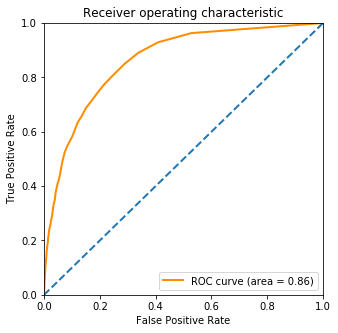

In [75]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

 Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.26')

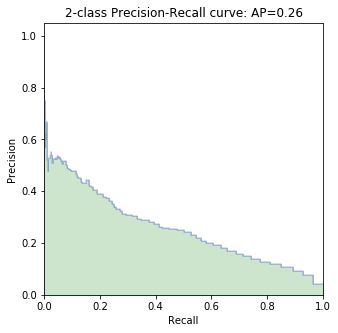

In [83]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature


average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (5, 5))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

A better metric in this imbalanced situation is the AUC PR (Area Under the Curve Precision Recall), or also called AP (Average Precision). We can see that the precision decreases when we increase the recall.

To assess the quality of our model, we can compare it to a simple decision baseline. Let’s take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.
The AP of our model is approximately 0.3, which is great, It means that our model has a good predictive power.